In [1]:
import os 
import pandas as pd
import joblib 
from dispersant_screener.ga import run_ga, FEATURES
from dispersant_screener.definitions import FEATURES as FEATURES_used
from dispersant_screener.gp import predict_coregionalized
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

import numpy as np 
DATADIR = '../data'

In [22]:
# Rg
config_0 = {
    'max_depth': 81,
    'reg_alpha': 1.0059223601214005,
    'subsample': 0.4323683292622177,
    'num_leaves': 14,
    'reg_lambda': 1.3804842496500522,
    'n_estimators': 3771,
    'colsample_bytree': 0.9897619355459844,
    'min_child_weight': 0.036693782744867405
}

# Delta G
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/wog4qfb2/overview?workspace=user-kjappelbaum
config_1 = {
    'max_depth': 73,
    'reg_alpha': 1.392732983015451,
    'subsample': 0.5009306968568509,
    'num_leaves': 6,
    'reg_lambda': 1.0595847294980203,
    'n_estimators': 461,
    'colsample_bytree': 0.966043658485258,
    'min_child_weight': 0.0039362945584385705
}

# repulsion
# https://app.wandb.ai/kjappelbaum/dispersant_screener/runs/ljzi9uad/overview?workspace=user-kjappelbaum
config_2 = {
    'max_depth': 22,
    'reg_alpha': 1.4445428983500173,
    'subsample': 0.37540621157955995,
    'num_leaves': 11,
    'reg_lambda': 1.246760700982355,
    'n_estimators': 56,
    'colsample_bytree': 0.9850898928749316,
    'min_child_weight': 0.05716405492260722
}

df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES_used].values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    gibbs.reshape(-1, 1) * (-1),
    gibbs_max.reshape(-1, 1),
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)



For building the surrogate model, we train GBDT models to predict the predictions of the GPR 

In [23]:
X_test = np.load('../work/20200830-112437-X_test.npy')
X_train = np.load('../work/20200830-112437-X_train.npy')

y_test = np.load('../work/20200830-112437-y_test.npy')
y_train = np.load('../work/20200830-112437-y_train.npy')

In [24]:
ground_true = np.vstack([y_test, y_train])

In [25]:
models = joblib.load('../work/20200830-112437models.joblib')

In [26]:
X = np.vstack([X_test, X_train])

In [27]:
len(X)

3125

In [28]:
len(ground_true)

3125

In [48]:
y_pred_0, _ = predict_coregionalized(models[0], X, 0)
y_pred_1, _ = predict_coregionalized(models[0], X, 1)
y_pred_2, _ = predict_coregionalized(models[0], X, 2)

In [61]:
y_train = np.hstack([y_pred_0[:,0].reshape(-1,1), y_pred_1[:,0].reshape(-1,1), y_pred_2[:,0].reshape(-1,1)])

In [31]:
feats = []
feat_names = []
for i, feat in enumerate(np.array(FEATURES_used)): 
    if feat in ['max_[Ta]', 'max_[W]', 'max_[R]', 'max_[Tr]', '[W]', '[Tr]', '[Ta]', '[R]', 'length']: 
        feats.append(i)
        feat_names.append(feat)

In [32]:
len(feats)

9

In [63]:
y_train[:,0].max()

2.7277358381109464

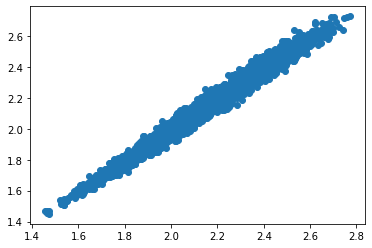

In [34]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.scatter(ground_true[:,0], y_pred_0[:,0])

In [64]:
np.save('../work/X_train_GBDT.npy', X[:,feats])
np.save('../work/y_train_GBDT.npy', y_train)

In [92]:
y_train.shape

(3125, 3)

In [93]:
X.shape

(3125, 14)

In [108]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [105]:
lgbm = LGBMRegressor()

In [107]:
X, y = X[:,feats], y_train[:,0]

In [109]:
scores = []

for i in range(5): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)
    lgbm.fit(X_train, y_train)
    scores.append(r2_score(lgbm.predict(X_test), y_test))

In [110]:
scores

[0.9514167295673676,
 0.9493298621827934,
 0.9436680919812326,
 0.9441133598278459,
 0.928536154909106]

In [99]:
from sklearn.metrics import r2_score

In [100]:
r2_score(lgbm.predict( X[:,feats]), y_train[:,0])

0.9699630401323753

In [106]:
cross_val_score(lgbm,  X[:,feats], y_train[:,0], scoring='r2', n_jobs=-1)

array([-520.01402872,   -9.22741155, -563.46031912])

In [16]:
len(FEATURES_used)

14

In [18]:
feat_names

['max_[W]',
 'max_[Tr]',
 'max_[Ta]',
 'max_[R]',
 '[W]',
 '[Tr]',
 '[Ta]',
 '[R]',
 'length']

In [22]:
max(y_pred_0)

array([2.72773584])

In [23]:
max(y_pred_1)

array([19.67135814])

In [24]:
max(y_pred_2)

array([2.77178359])